In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Load Data

In [2]:
def preprocess_data(pos_file_path=None, neg_file_path=None, categorical_columns=None, label_col="label", test_size=0.2, random_state=0):
    # Initialize an empty DataFrame for concatenation
    data_frames = []
    
    # Load positive dataset if the path is provided
    if pos_file_path is not None:
        pos_df = pd.read_csv(pos_file_path)
        pos_df[label_col] = 1  # Label positive samples as 1
        data_frames.append(pos_df)
    
    # Load negative dataset if the path is provided
    if neg_file_path is not None:
        neg_df = pd.read_csv(neg_file_path)
        neg_df[label_col] = 0  # Label negative samples as 0
        data_frames.append(neg_df)
    
    # Concatenate available datasets
    if not data_frames:
        raise ValueError("At least one of pos_file_path or neg_file_path must be provided.")
    data_df = pd.concat(data_frames, axis=0)
    
    # Drop unnecessary columns if present
    #if 'dod' in data_df.columns:
    #    data_df.drop(columns=['dod'], inplace=True)
    
    # Split into features and labels
    X = data_df.drop(columns=[label_col, "subject_id"])
    y = data_df[label_col]
    
    # Encode categorical columns
    #if categorical_columns:
    #    for col in categorical_columns:
    #        le = LabelEncoder()
    #        X[col] = le.fit_transform(X[col].astype(str))
    
    # Fill missing values with column means
    #X.fillna(X.mean(), inplace=True)
    
    # Standardize numerical features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split into training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_valid, y_train, y_valid

# Usage
pos_file_path = "generic_features_for_positive_patient.csv"
neg_file_path = "generic_features_for_random_patient.csv"
CAT_COLUMN = ['race', 'marital_status', 'gender', 'dod']

X_train, X_valid, y_train, y_valid = preprocess_data(pos_file_path, neg_file_path, CAT_COLUMN, label_col="label")





In [3]:
# create shuffled_data for feature importances
df1 = pd.read_csv('generic_features_for_random_patient.csv')
df1["hiv"] = 0
df2 = pd.read_csv('generic_features_for_positive_patient.csv')
df2["hiv"] = 1

shuffled_data = pd.concat([df1, df2], ignore_index=True)

### Initial Training

In [4]:
# Initialize TabNet model
model = TabNetClassifier()


# Train the model
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    max_epochs=100,
    patience=10,
    batch_size=1024, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Predictions
y_pred_tabnet = model.predict(X_valid)
y_pred_proba_tabnet = model.predict_proba(X_valid)[:, 1]



accuracy = accuracy_score(y_valid, y_pred_tabnet)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

report = classification_report(y_valid, y_pred_tabnet)
print(report)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69196 | val_0_auc: 0.70513 |  0:00:00s
epoch 1  | loss: 0.6237  | val_0_auc: 0.82213 |  0:00:00s
epoch 2  | loss: 0.54401 | val_0_auc: 0.85717 |  0:00:00s
epoch 3  | loss: 0.48022 | val_0_auc: 0.88485 |  0:00:00s
epoch 4  | loss: 0.4574  | val_0_auc: 0.89    |  0:00:00s
epoch 5  | loss: 0.41935 | val_0_auc: 0.90642 |  0:00:00s
epoch 6  | loss: 0.39799 | val_0_auc: 0.91367 |  0:00:00s
epoch 7  | loss: 0.37712 | val_0_auc: 0.9214  |  0:00:01s
epoch 8  | loss: 0.37082 | val_0_auc: 0.92874 |  0:00:01s
epoch 9  | loss: 0.36181 | val_0_auc: 0.92993 |  0:00:01s
epoch 10 | loss: 0.35238 | val_0_auc: 0.93075 |  0:00:01s
epoch 11 | loss: 0.35215 | val_0_auc: 0.9336  |  0:00:01s
epoch 12 | loss: 0.34514 | val_0_auc: 0.93684 |  0:00:01s
epoch 13 | loss: 0.33531 | val_0_auc: 0.93631 |  0:00:01s
epoch 14 | loss: 0.33261 | val_0_auc: 0.93777 |  0:00:01s
epoch 15 | loss: 0.33375 | val_0_auc: 0.94138 |  0:00:02s
epoch 16 | loss: 0.32221 | val_0_auc: 0.94356 |  0:00:02s
epoch 17 | los

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


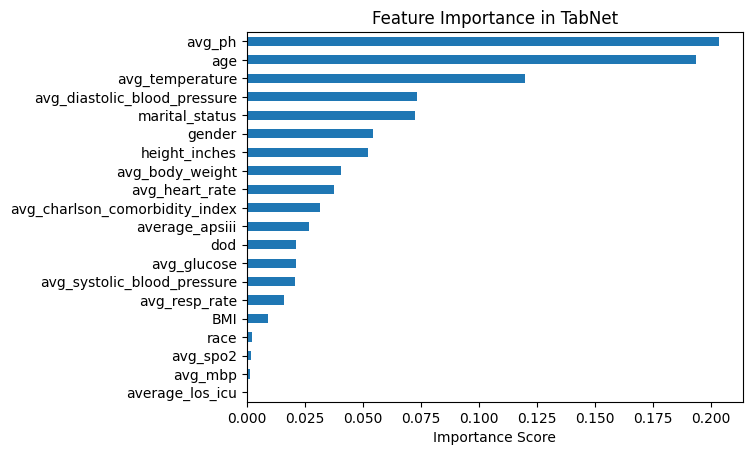

In [5]:
# data received from separate codesheet

data = {
    'race': 0.0021550639560379108,
    'marital_status': 0.07263022284860916,
    'age': 0.1935844041026247,
    'average_apsiii': 0.02673013617234582,
    'avg_charlson_comorbidity_index': 0.03169528516412599,
    'gender': 0.054589863364509376,
    'dod': 0.02127761062733792,
    'avg_ph': 0.20356743019347365,
    'avg_body_weight': 0.04065667136613818,
    'BMI': 0.009111778991516951,
    'height_inches': 0.052398351611021826,
    'average_los_icu': 5.025734337689912e-06,
    'avg_glucose': 0.02107819875087031,
    'avg_heart_rate': 0.03754229765893099,
    'avg_mbp': 0.0015110488155761698,
    'avg_resp_rate': 0.015965659398276894,
    'avg_spo2': 0.0017490473816516216,
    'avg_temperature': 0.11976966828198839,
    'avg_systolic_blood_pressure': 0.02066167261337099,
    'avg_diastolic_blood_pressure': 0.07332056296725535
}

importance = pd.Series(data)

# Plot the feature importance
importance.sort_values().plot(kind='barh')
plt.title('Feature Importance in TabNet')
plt.xlabel('Importance Score')
plt.show()

In [6]:
model_lr = LogisticRegression(random_state=90089)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_valid)
y_pred_proba_lr = model_lr.predict_proba(X_valid)[:, 1]
accuracy_lr = accuracy_score(y_valid, y_pred_lr)
print(f"Accuracy: {accuracy_lr}")
report = classification_report(y_valid, y_pred_lr)
print(report)

Accuracy: 0.8503611971104231
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       510
           1       0.85      0.83      0.84       459

    accuracy                           0.85       969
   macro avg       0.85      0.85      0.85       969
weighted avg       0.85      0.85      0.85       969



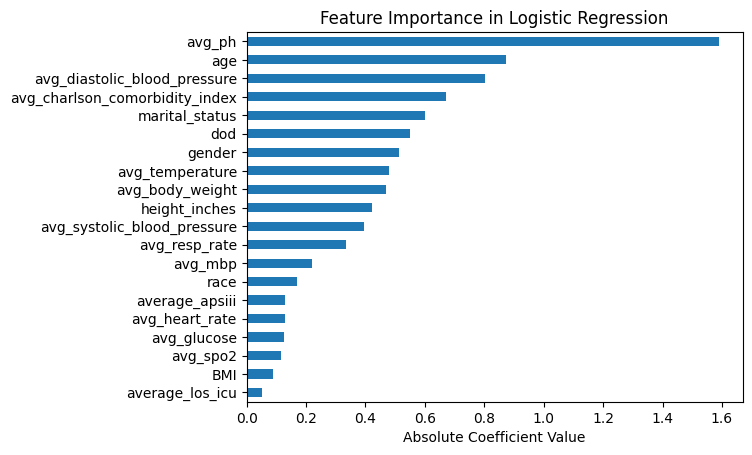

In [7]:
feature_columns = shuffled_data.columns.drop(['hiv', 'subject_id']).tolist()
importance = pd.Series(model_lr.coef_[0], index=feature_columns).abs()

# Plot feature importance
importance.sort_values().plot(kind='barh')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.show()

In [8]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_valid)
y_pred_proba_rf = model_rf.predict_proba(X_valid)[:, 1]
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Accuracy: {accuracy_rf}")
report = classification_report(y_valid, y_pred_rf)
print(report)

Accuracy: 0.9040247678018576
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       510
           1       0.91      0.88      0.90       459

    accuracy                           0.90       969
   macro avg       0.90      0.90      0.90       969
weighted avg       0.90      0.90      0.90       969



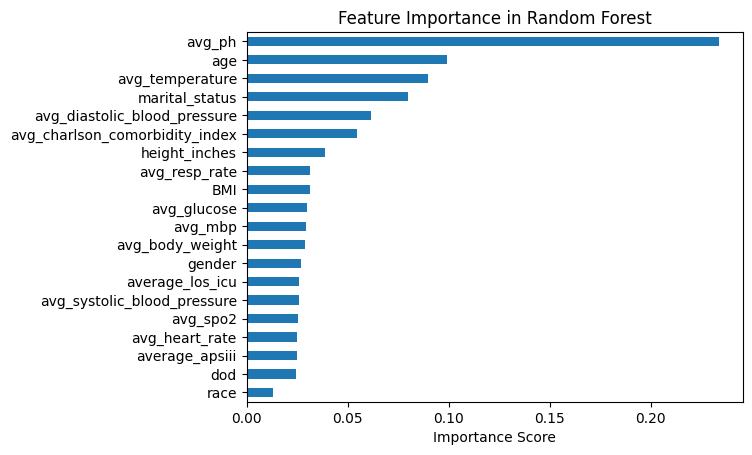

In [10]:
# Get feature importance
importance = pd.Series(model_rf.feature_importances_, index=feature_columns)

# Plot feature importance
importance.sort_values().plot(kind='barh')
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance Score')
plt.show()

### AUROC Score and ROC Curve

969
969
AUROC Score LR: 0.9346875133495663
AUROC Score RF: 0.9733649451065829
AUROC Score TabNet: 0.9571404160792857


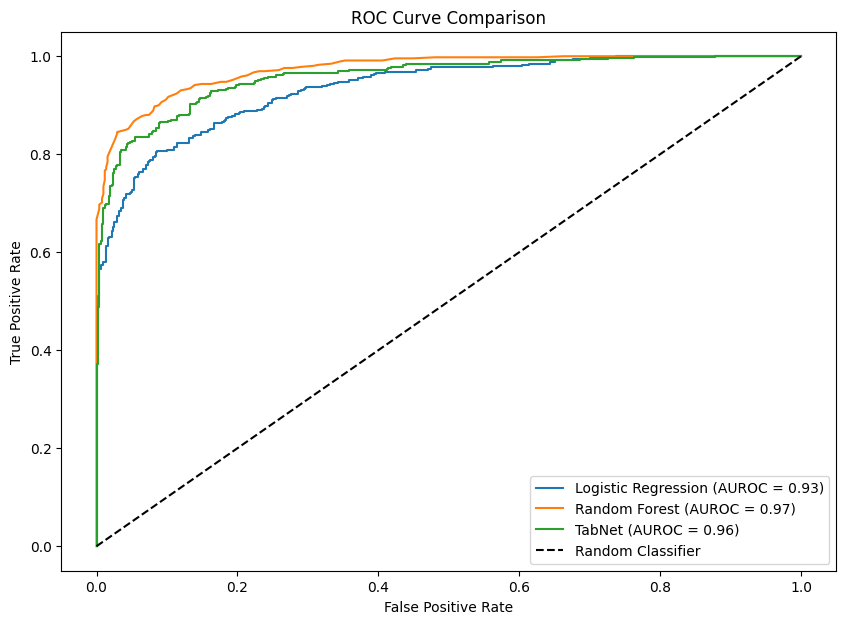

In [11]:
# Evaluate the model auroc score
print(len(y_valid))
print(len(y_pred_proba_lr))
auroc_lr = roc_auc_score(y_valid, y_pred_proba_lr)
auroc_rf = roc_auc_score(y_valid, y_pred_proba_rf)
auroc_tabnet = roc_auc_score(y_valid, y_pred_proba_tabnet)
print("AUROC Score LR:", auroc_lr)
print("AUROC Score RF:", auroc_rf)
print("AUROC Score TabNet:", auroc_tabnet)

# graph
fpr_lr, tpr_lr, _ = roc_curve(y_valid, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_valid, y_pred_proba_rf)
fpr_tabnet, tpr_tabnet, _ = roc_curve(y_valid, y_pred_proba_tabnet)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUROC = {auroc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUROC = {auroc_rf:.2f})')
plt.plot(fpr_tabnet, tpr_tabnet, label=f'TabNet (AUROC = {auroc_tabnet:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()